# 1st Place Solution Training & Testing Code

Hi, all,

We're very exciting to writing this notebook and the summary of our solution here.

This is a small version (b3 w/ input size 256 training for only 5 epochs) of our training & testing pipeline only for demonstrating our ideas and methods.

To get a similar result of a single model to ours, you only need to do:

* set `DEBUG` to `False`
* train for 15 epochs for each fold
* using apex
* change the model type to effnet-b4/b5/b6/b7
* modify the input size to 384 or 512 or 640 (do remember to use bigger dataset as well)
* keep batch size >= 36 (may have to use multi-gpus)

Our brief summary of winning solution:
https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175412


# Main Ideas

* apex amp (install apex into kaggle kernel is hard, so I skipped it)
* use meta data
* optimized augmentation methods
* 9 classes w/ CrossEntropyLoss
* warmup + cosine scheduler
* rank per fold before ensemble

# Thanks!

In [1]:
DEBUG = True

In [2]:
!pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip -q install geffnet

In [3]:
import os
import sys
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler  # https://github.com/ildoonet/pytorch-gradual-warmup-lr
import albumentations as A
import geffnet

device = torch.device('cuda')

# Config

In [4]:
kernel_type = 'effnetb3_256_meta_9c_ext_5epo'
image_size = 256
use_amp = False
data_dir = '../input/jpeg-melanoma-256x256'
data_dir2 = '../input/jpeg-isic2019-256x256'
enet_type = 'efficientnet-b3'
batch_size = 64
num_workers = 4
init_lr = 3e-5
out_dim = 9

freeze_epo = 0
warmup_epo = 1
cosine_epo = 4
n_epochs = freeze_epo + warmup_epo + cosine_epo

use_external = '_ext' in kernel_type
use_meta = 'meta' in kernel_type

# Read CSV & Target Preprocess

In [5]:
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(data_dir, 'test', f'{x}.jpg'))

In [6]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train = df_train[df_train['tfrecord'] != -1].reset_index(drop=True)
# df_train['fold'] = df_train['tfrecord'] % 5
tfrecord2fold = {
    2:0, 4:0, 5:0,
    1:1, 10:1, 13:1,
    0:2, 9:2, 12:2,
    3:3, 8:3, 11:3,
    6:4, 7:4, 14:4,
}
df_train['fold'] = df_train['tfrecord'].map(tfrecord2fold)
df_train['is_ext'] = 0
df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(data_dir, 'train', f'{x}.jpg'))


df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
df_train['diagnosis'] = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

df_train['diagnosis'].value_counts()

diagnosis
unknown     26699
nevus        5191
melanoma      581
BKL           221
Name: count, dtype: int64

In [7]:
if use_external:
    df_train2 = pd.read_csv(os.path.join(data_dir2, 'train.csv'))
    df_train2 = df_train2[df_train2['tfrecord'] >= 0].reset_index(drop=True)
    df_train2['fold'] = df_train2['tfrecord'] % 5
    df_train2['is_ext'] = 1
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(data_dir2, 'train', f'{x}.jpg'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
mel_idx = diagnosis2idx['melanoma']
diagnosis2idx

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'SCC': 4,
 'VASC': 5,
 'melanoma': 6,
 'nevus': 7,
 'unknown': 8}

In [8]:
df_train['target'].value_counts()

target
8    26699
7    18031
6     5090
1     3320
2     2837
0      867
4      628
5      253
3      239
Name: count, dtype: int64

# Preprocess Meta Data

In [9]:
df_train.filepath

0        ../input/jpeg-melanoma-256x256/train/ISIC_2637...
1        ../input/jpeg-melanoma-256x256/train/ISIC_0015...
2        ../input/jpeg-melanoma-256x256/train/ISIC_0052...
3        ../input/jpeg-melanoma-256x256/train/ISIC_0068...
4        ../input/jpeg-melanoma-256x256/train/ISIC_0074...
                               ...                        
57959    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57960    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57961    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57962    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
57963    ../input/jpeg-isic2019-256x256/train/ISIC_0073...
Name: filepath, Length: 57964, dtype: object

In [10]:
if use_meta:
    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([df_train['anatom_site_general_challenge'], df_test['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    df_train = pd.concat([df_train, dummies.iloc[:df_train.shape[0]]], axis=1)
    df_test = pd.concat([df_test, dummies.iloc[df_train.shape[0]:].reset_index(drop=True)], axis=1)
    # Sex features
    df_train['sex'] = df_train['sex'].map({'male': 1, 'female': 0})
    df_test['sex'] = df_test['sex'].map({'male': 1, 'female': 0})
    df_train['sex'] = df_train['sex'].fillna(-1)
    df_test['sex'] = df_test['sex'].fillna(-1)
    # Age features
    df_train['age_approx'] /= 90
    df_test['age_approx'] /= 90
    df_train['age_approx'] = df_train['age_approx'].fillna(0)
    df_test['age_approx'] = df_test['age_approx'].fillna(0)
    df_train['patient_id'] = df_train['patient_id'].fillna(0)
    # n_image per user
    df_train['n_images'] = df_train.patient_id.map(df_train.groupby(['patient_id']).image_name.count())
    df_test['n_images'] = df_test.patient_id.map(df_test.groupby(['patient_id']).image_name.count())
    df_train.loc[df_train['patient_id'] == -1, 'n_images'] = 1
    df_train['n_images'] = np.log1p(df_train['n_images'].values)
    df_test['n_images'] = np.log1p(df_test['n_images'].values)
    # image size
    train_images = df_train['filepath'].values
    train_sizes = np.zeros(train_images.shape[0])
    for i, img_path in enumerate(tqdm(train_images)):
        train_sizes[i] = os.path.getsize(img_path)
    df_train['image_size'] = np.log(train_sizes)
    test_images = df_test['filepath'].values
    test_sizes = np.zeros(test_images.shape[0])
    for i, img_path in enumerate(tqdm(test_images)):
        test_sizes[i] = os.path.getsize(img_path)
    df_test['image_size'] = np.log(test_sizes)
    meta_features = ['sex', 'age_approx', 'n_images', 'image_size'] + [col for col in df_train.columns if col.startswith('site_')]
    n_meta_features = len(meta_features)
else:
    n_meta_features = 0

  0%|          | 0/57964 [00:00<?, ?it/s]

  0%|          | 0/10982 [00:00<?, ?it/s]

In [11]:
n_meta_features

14

# Define Dataset

In [12]:
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,site_lateral torso,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_torso,site_upper extremity,site_nan,n_images,image_size
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,unknown,benign,8,0,6000,...,0,0,0,0,0,0,0,0,4.753590,9.963783
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,unknown,benign,8,0,6000,...,0,0,0,0,0,0,1,0,3.218876,10.020871
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,nevus,benign,7,6,1872,...,0,1,0,0,0,0,0,0,1.791759,9.791829
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,unknown,benign,8,0,1872,...,0,0,0,0,0,0,0,0,3.135494,10.342226
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,unknown,benign,8,11,6000,...,0,0,0,0,0,0,1,0,3.044522,9.928570


In [24]:
df_train.target.value_counts()
df_train[df_train.fold==7].shape

(0, 26)

In [77]:
class SIIMISICDataset(Dataset):
    def __init__(self, csv, split, mode, transform=None, pre_proc_path="../input/preprocessed"):

        self.csv = csv.reset_index(drop=True)
        self.split = split
        self.mode = mode
        self.transform = transform
        self.pre_proc_path = pre_proc_path
        self.pre_proc_files = []

        if transform is not None:
            self.csv.set_index("image_name", inplace=True)
            import uuid
            os.makedirs(pre_proc_path, exist_ok=True)
            for ind, row in self.csv.iterrows():
                image = cv2.imread(row.filepath)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                for i in range(n_epochs):
                    res = transform(image=image)
                    image_name = f"{os.path.basename(row.filepath)}{uuid.uuid4().hex}.jpg"
                    cv2.imwrite(os.path.join(pre_proc_path, image_name), res["image"])
                    self.pre_proc_files.append(image_name)
                    
                    if not self.mode=="train":
                        break

    def __len__(self):
        if self.transform:
            return len(self.pre_proc_files)
        return self.csv.shape[0]

    def __getitem__(self, index):        
        if self.transform is not None:
            image = cv2.imread(os.path.join(self.pre_proc_path, self.pre_proc_files[index]))
            index = self.pre_proc_files[index].split(".")[0]
        else:
            row = self.csv.iloc[index]
            image = cv2.imread(row.filepath)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        image = image.astype(np.float32)
        image = image.transpose(2, 0, 1)

        if use_meta:
            data = (torch.tensor(image).float(), torch.tensor(self.csv.loc[index][meta_features]).float())
        else:
            data = torch.tensor(image).float()

        if self.mode == 'test':
            return data
        else:
            return data, torch.tensor(self.csv.loc[index].target).long()

# Augmentations

In [59]:
transforms_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),

    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(image_size, image_size),
    A.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),    
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

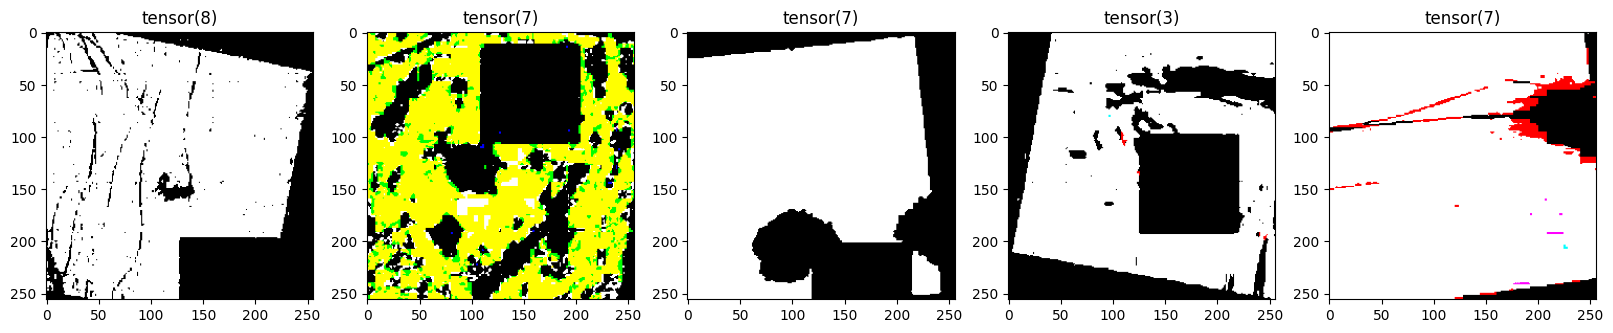

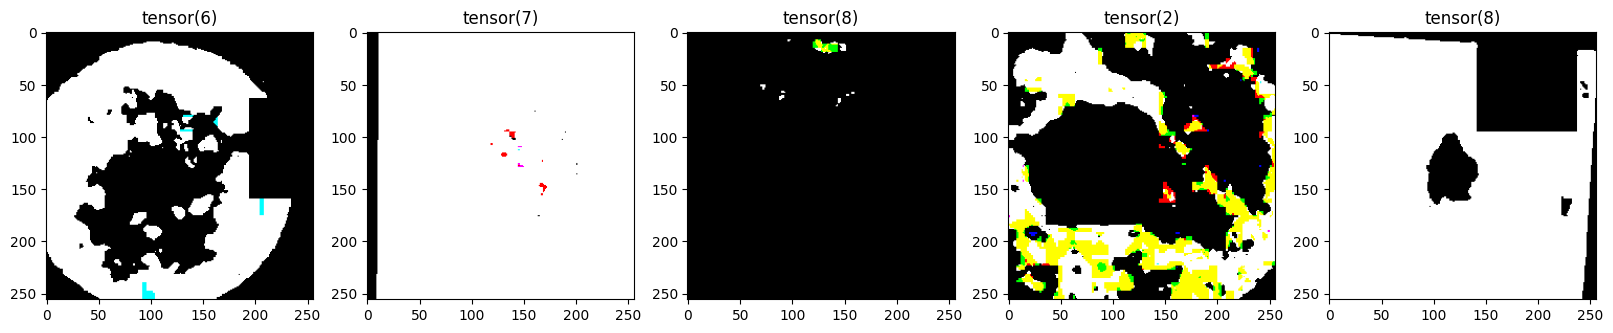

In [60]:
df_show = df_train.sample(1000)
dataset_show = SIIMISICDataset(df_show, 'train', 'train', transform=transforms_train)

from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        if use_meta:
            img = img[0]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(label))

# Model

In [61]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)
swish_layer = Swish_module()

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim, n_meta_features=0, load_pretrained=True):

        super(enetv2, self).__init__()
        self.n_meta_features = n_meta_features
        self.enet = geffnet.create_model(enet_type.replace('-', '_'), pretrained=True)
        self.dropout = nn.Dropout(0.5)
        in_ch = self.enet.classifier.in_features
        if n_meta_features > 0:
            self.meta = nn.Sequential(
                nn.Linear(n_meta_features, 512),
                nn.BatchNorm1d(512),
                Swish_module(),
                nn.Dropout(p=0.3),
                nn.Linear(512, 128),
                nn.BatchNorm1d(128),
                Swish_module(),
            )
            in_ch += 128
        self.myfc = nn.Linear(in_ch, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        x = self.enet(x)
        return x

    def forward(self, x, x_meta=None):
        x = self.extract(x).squeeze(-1).squeeze(-1)
        if self.n_meta_features > 0:
            x_meta = self.meta(x_meta)
            x = torch.cat((x, x_meta), dim=1)
            x = self.myfc(self.dropout(x))
        return x

# Loss Function

In [62]:
criterion = nn.CrossEntropyLoss()

# Train & Valid Function

In [63]:
def train_epoch(model, loader, optimizer, log_every=1000):
    model.train()
    train_loss = []
    bar = tqdm(loader)
    for i, (data, target) in enumerate(bar):
        optimizer.zero_grad()
        if use_meta:
            data, meta = data
            data, meta, target = data.to(device), meta.to(device), target.to(device)
            logits = model(data, meta)
        else:
            data, target = data.to(device), target.to(device)
            logits = model(data)
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

    
def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):
    model.eval()
    val_loss = []
    LOGITS = []
    PROBS = []
    TARGETS = []
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            
            if use_meta:
                data, meta = data
                data, meta, target = data.to(device), meta.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data, target = data.to(device), target.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test

            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())
            TARGETS.append(target.detach().cpu())

            loss = criterion(logits, target)
            val_loss.append(loss.detach().cpu().numpy())

    val_loss = np.mean(val_loss)
    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    TARGETS = torch.cat(TARGETS).numpy()

    if get_output:
        return PROBS
    else:
        acc = (PROBS.argmax(1) == TARGETS).mean() * 100.
        auc = roc_auc_score((TARGETS==mel_idx).astype(float), PROBS[:, mel_idx])
        auc_20 = roc_auc_score((TARGETS[is_ext==0]==mel_idx).astype(float), PROBS[is_ext==0, mel_idx])
        return val_loss, acc, auc, auc_20

In [64]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [82]:
df_train.shape

(57964, 26)

: 

In [75]:
def run(fold):
    
    i_fold = fold

    if DEBUG:
        df_this = df_train[df_train['fold'] != i_fold].sample(batch_size * 3)
        df_valid = df_train[df_train['fold'] == i_fold].sample(batch_size * 3)
    else:
        df_this = df_train[df_train['fold'] != i_fold]
        df_valid = df_train[df_train['fold'] == i_fold]

    dataset_train = SIIMISICDataset(df_this,  'train', 'train', transform=transforms_train)
    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)

    auc_max = 0.
    auc_20_max = 0.
    model_file = f'{kernel_type}_best_fold{i_fold}.pth'
    model_file2 = f'{kernel_type}_best_o_fold{i_fold}.pth'

    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    if use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))
    
    total_iter = len(dataset_train)
    train_loss = []
    for it, (data, target) in enumerate(bar := tqdm(train_loader)):
        epoch = it % (total_iter//n_epochs)
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

#         train_loss = train_epoch(model, train_loader, optimizer, log_every)
        model.train()
        
#         for i, (data, target) in enumerate(bar):
        optimizer.zero_grad()
        if use_meta:
            data, meta = data
            data, meta, target = data.to(device), meta.to(device), target.to(device)
            logits = model(data, meta)
        else:
            data, target = data.to(device), target.to(device)
            logits = model(data)
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
        
        # if it%(len(dataset_train)//n_epochs)==0:
        

#         if it%(len(dataset_train)//n_epochs)==0:
#             content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}, auc_20: {(auc_20):.6f}.'
#             print(content)
#             with open(f'log_{kernel_type}.txt', 'a') as appender:
#                 appender.write(content + '\n')

#             if auc > auc_max:
#                 print('auc_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_max, auc))
#                 torch.save(model.state_dict(), model_file)
#                 auc_max = auc
#             if auc_20 > auc_20_max:
#                 print('auc_20_max ({:.6f} --> {:.6f}). Saving model ...'.format(auc_20_max, auc_20))
#                 torch.save(model.state_dict(), model_file2)
#                 auc_20_max = auc_20

#             scores.append(auc_max)
#             scores_20.append(auc_20_max)
    val_loss, acc, auc, auc_20 = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values)
    print(val_loss, acc, auc, auc_20)
    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_model_fold{i_fold}.pth'))

# Run 5-Fold Training

In [66]:
scores = []
scores_20 = []

In [78]:
for fold in range(1):
    run(fold)

960 192


  0%|          | 0/15 [00:00<?, ?it/s]

Sun Aug  6 16:41:58 2023 Epoch: 0


/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please

Sun Aug  6 16:41:58 2023 Epoch: 1
Sun Aug  6 16:41:58 2023 Epoch: 2
Sun Aug  6 16:41:59 2023 Epoch: 3


/home/ridwan.salahuddeen/.conda/envs/codeformer/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Sun Aug  6 16:41:59 2023 Epoch: 4
Sun Aug  6 16:41:59 2023 Epoch: 5
Sun Aug  6 16:42:00 2023 Epoch: 6
Sun Aug  6 16:42:00 2023 Epoch: 7
Sun Aug  6 16:42:00 2023 Epoch: 8
Sun Aug  6 16:42:01 2023 Epoch: 9
Sun Aug  6 16:42:01 2023 Epoch: 10
Sun Aug  6 16:42:01 2023 Epoch: 11
Sun Aug  6 16:42:02 2023 Epoch: 12
Sun Aug  6 16:42:02 2023 Epoch: 13
Sun Aug  6 16:42:02 2023 Epoch: 14


  0%|          | 0/3 [00:00<?, ?it/s]

1.7262665 62.5 0.5610795454545454 0.49056603773584906


In [70]:
print(scores)
print(scores_20)

[]
[]


# Get OOF and CV score

In [71]:
PROBS = []
dfs = []

for fold in range(5):
    i_fold = fold

    df_valid = df_train[df_train['fold'] == i_fold]
    dataset_valid = SIIMISICDataset(df_valid, 'train', 'val', transform=transforms_val)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, num_workers=num_workers)

    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)
    model_file = f'{kernel_type}_fold{i_fold}.pth'
    model.load_state_dict(torch.load(model_file), strict=True)
    model.eval()

    this_PROBS = val_epoch(model, valid_loader, is_ext=df_valid['is_ext'].values, n_test=8, get_output=True)
    PROBS.append(this_PROBS)
    dfs.append(df_valid)

dfs = pd.concat(dfs).reset_index(drop=True)
dfs['pred'] = np.concatenate(PROBS).squeeze()[:, mel_idx]

FileNotFoundError: [Errno 2] No such file or directory: 'effnetb3_256_meta_9c_ext_5epo_best_fold0.pth'

In [ ]:
# Raw auc_all
roc_auc_score(dfs['target'] == mel_idx, dfs['pred'])

In [ ]:
# Rank per fold auc_all
dfs2 = dfs.copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

In [ ]:
# Raw auc_2020
roc_auc_score(dfs[dfs['is_ext']==0]['target']==mel_idx, dfs[dfs['is_ext']==0]['pred'])

In [ ]:
# Rank per fold auc_2020
dfs2 = dfs[dfs.is_ext==0].copy()
for i in range(5):
    dfs2.loc[dfs2['fold']==i, 'pred'] = dfs2.loc[dfs2['fold']==i, 'pred'].rank(pct=True)
roc_auc_score(dfs2['target'] == mel_idx, dfs2['pred'])

# Predict

In [ ]:
n_test = 8
dataset_test = SIIMISICDataset(df_test, 'test', 'test', transform=transforms_val)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers)

In [ ]:
OUTPUTS = []

for fold in range(5):
    model = enetv2(enet_type, n_meta_features=n_meta_features, out_dim=out_dim)
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join('%s_best_fold%s.pth' % (kernel_type, fold))), strict=True)
    model.eval()
    
    LOGITS = []
    PROBS = []

    with torch.no_grad():
        for (data) in tqdm(test_loader):
            
            if use_meta:
                data, meta = data
                data, meta = data.to(device), meta.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I), meta)
                    logits += l
                    probs += l.softmax(1)
            else:
                data = data.to(device)
                logits = torch.zeros((data.shape[0], out_dim)).to(device)
                probs = torch.zeros((data.shape[0], out_dim)).to(device)
                for I in range(n_test):
                    l = model(get_trans(data, I))
                    logits += l
                    probs += l.softmax(1)
            logits /= n_test
            probs /= n_test
    
            LOGITS.append(logits.detach().cpu())
            PROBS.append(probs.detach().cpu())

    LOGITS = torch.cat(LOGITS).numpy()
    PROBS = torch.cat(PROBS).numpy()
    
    OUTPUTS.append(PROBS[:, mel_idx])

In [ ]:
# Rank per fold
pred = np.zeros(OUTPUTS[0].shape[0])
for probs in OUTPUTS:
    pred += pd.Series(probs).rank(pct=True).values
pred /= len(OUTPUTS)

# Submit to Kaggle

In [ ]:
df_test['target'] = pred
df_test[['image_name', 'target']].to_csv(f'submission.csv', index=False)

In [ ]:
df_test.head()